In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
path_to_dataset = "/fastdata/vilab24/meta-album"

# Confidence Estimation

In [4]:
import pathlib
import cdmetadl

PROJECT_DIR = pathlib.Path(cdmetadl.__file__).parent.parent

In [5]:
import pathlib

import cdmetadl.helpers.general_helpers
import cdmetadl.dataset

dataset_path = pathlib.Path(path_to_dataset)
dataset_info_dict = cdmetadl.helpers.general_helpers.check_datasets(dataset_path, ["SPT"])

dataset = cdmetadl.dataset.ImageDataset("Sports", dataset_info_dict["SPT"])

In [6]:
import cdmetadl.samplers

n_way_sampler = cdmetadl.samplers.ValueSampler(value=5)
k_shot_sampler = cdmetadl.samplers.ValueSampler(value=4)

task = dataset.generate_task(n_way_sampler, k_shot_sampler, query_size=4)

In [28]:
import cdmetadl.helpers.general_helpers

model_module = cdmetadl.helpers.general_helpers.load_module_from_path(PROJECT_DIR / "baselines/finetuning/model.py")
learner = model_module.MyLearner()
learner.load("/fastdata/vilab24/output/full/training/dropout_50/finetuning/cross-domain/model")

## Pseudo Confidence Estimation

[0.0, 0.28110530972480774, 0.34031397104263306, 0.512093, 0.0]


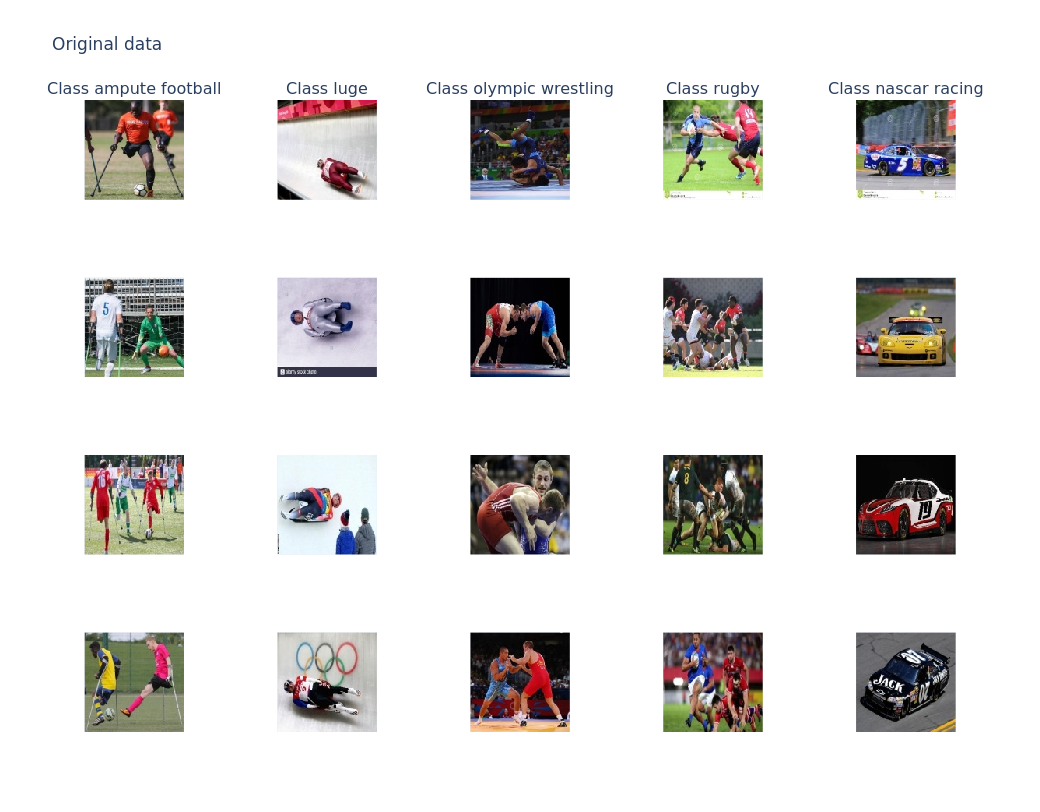

In [30]:
import cdmetadl.confidence
import cdmetadl.notebooks.helpers

confidence_estimator = cdmetadl.confidence.PseudoConfidenceEstimator()
_, confidence_scores = confidence_estimator.estimate(learner, task.support_set)
print(confidence_scores)

fig = cdmetadl.notebooks.helpers.show_images_grid_plotly(task.support_set, True)

# [0.0, 0.0,                 0.2769032418727875, 0.25117751955986023, 0.0]
# [0.0, 0.16694778203964233, 0.2261287271976471, 0.3138962686061859,  0.0]
# [0.0, 0.15397265553474426, 0.2813131809234619, 0.23871740698814392, 0.0]

## Monte Carlo Dropout Confidence Estimation

In [35]:
import cdmetadl.confidence
import cdmetadl.notebooks.helpers

confidence_estimator = cdmetadl.confidence.MCDropoutConfidenceEstimator(num_samples=1000)
_, confidence_scores = confidence_estimator.estimate(learner, task.support_set)
print(confidence_scores)

fig = cdmetadl.notebooks.helpers.show_images_grid_plotly(task.support_set, True)
# [0.7774086017161608, 0.6927578523755074, 0.6273656897246838, 0.6183898355811834, 0.4825338535010816]
# [0.628645233809948, 0.7149003259837627, 0.6990674696862698, 0.6308220606297255, 0.7006687857210636]
# [0.7290910743176937, 0.7229419238865376, 0.6971153244376183, 0.556826526299119, 0.5891343858093023]

# [0.351768620312214, 0.056045763194561116, 0.6225202046334743, 0.4780894424766303, 0.33723104745149624]
# [0.28700584545731556, 0.5543503258377314, 0.562587222084403, 0.4546942934393884, 0.5707808583974838]
# [0.692739225924015, 0.3485971875488759, 0.4613974876701833, 0.5356012191623449, 0.3551560267806054]

[[0.22730227 0.24855706 0.21784149 0.20799963 0.1528934 ]
 [0.1926222  0.25887367 0.24489184 0.21820503 0.15718241]
 [0.20509833 0.25140348 0.2485664  0.23556377 0.17389348]
 ...
 [0.22423537 0.23613632 0.24778609 0.22969174 0.14421819]
 [0.22813503 0.26572296 0.26054287 0.22427592 0.15569316]
 [0.22403455 0.24315393 0.26672357 0.21802941 0.13720539]]


KeyboardInterrupt: 